# About PyTorch

PyTorch was released in early 2017 and has been making a pretty big impact in the deep learning community. It's developed as an open source project by the Facebook AI Research team, but is being adopted by teams everywhere in industry and academia. In my experience, it's the best framework for learning deep learning and just a delight to work with in general.

In [123]:
# Imports

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import helper
import matplotlib.pyplot as plt

# Introduction to Deep Learning with PyTorch

In this notebook, you'll get introduced to [PyTorch](http://pytorch.org/), a framework for building and training neural networks. PyTorch in a lot of ways behaves like the arrays you love from Numpy. These Numpy arrays, after all, are just tensors. PyTorch takes these tensors and makes it simple to move them to GPUs for the faster processing needed when training neural networks. It also provides a module that automatically calculates gradients (for backpropagation!) and another module specifically for building neural networks. All together, PyTorch ends up being more coherent with Python and the Numpy/Scipy stack compared to TensorFlow and other frameworks.

# Neural Networks
Deep Learning is based on artificial neural networks which have been around in some form since the late 1950s. The networks are built from individual parts approximating neurons, typically called units or simply "neurons." Each unit has some number of weighted inputs. These weighted inputs are summed together (a linear combination) then passed through an activation function to get the unit's output.

Mathematically this looks like: 

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

With vectors this is the dot/inner product of two vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$

## Tensors

It turns out neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices.*** A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example).*** The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.

<img src="assets/tensor_examples.svg" width=600px>

With the basics covered, it's time to explore how we can use PyTorch to build a simple neural network.

In [53]:
def sigmoid(x):
    """ Sigmoid activation function 
    
        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

In [58]:
### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

feature = torch.randn((1,5)) # 5 Random Vectors w/ Shape (1 Row, 5 Column)
print(feature)

# Create weights with similar weights to feature - Normal Distribution
weights = torch.randn_like(feature)
print(weights)

# Create a bias term
bias = torch.randn((1,1))
print(bias)

tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]])
tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]])
tensor([[0.3177]])


Above I generated data we can use to get the output of our simple network. This is all just random for now, going forward we'll start using normal data. Going through each relevant line:

`features = torch.randn((1, 5))` creates a tensor with shape `(1, 5)`, one row and five columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one. 

`weights = torch.randn_like(features)` creates another tensor with the same shape as `features`, again containing values from a normal distribution.

Finally, `bias = torch.randn((1, 1))` creates a single value from a normal distribution.

PyTorch tensors can be added, multiplied, subtracted, etc, just like Numpy arrays. In general, you'll use PyTorch tensors pretty much the same way you'd use Numpy arrays. They come with some nice benefits though such as GPU acceleration which we'll get to later. For now, use the generated data to calculate the output of this simple single layer network. 
> **Exercise**: Calculate the output of the network with input features `features`, weights `weights`, and bias `bias`. Similar to Numpy, PyTorch has a [`torch.sum()`](https://pytorch.org/docs/stable/torch.html#torch.sum) function, as well as a `.sum()` method on tensors, for taking sums. Use the function `activation` defined above as the activation function.

In [59]:
# This is how you add
output = sigmoid(torch.sum(weights * feature)+ bias)
output

tensor([[0.1595]])

You can do the multiplication and sum in the same operation using a matrix multiplication. In general, you'll want to use matrix multiplications since they are more efficient and accelerated using modern libraries and high-performance computing on GPUs.

Here, we want to do a matrix multiplication of the features and the weights. For this we can use [`torch.mm()`](https://pytorch.org/docs/stable/torch.html#torch.mm) or [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul) which is somewhat more complicated and supports broadcasting. If we try to do it with `features` and `weights` as they are, we'll get an error

```python
>> torch.mm(features, weights)

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-13-15d592eb5279> in <module>()
----> 1 torch.mm(features, weights)

RuntimeError: size mismatch, m1: [1 x 5], m2: [1 x 5] at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/aten/src/TH/generic/THTensorMath.c:2033
```

As you're building neural networks in any framework, you'll see this often. Really often. What's happening here is our tensors aren't the correct shapes to perform a matrix multiplication. Remember that for matrix multiplications, the number of columns in the first tensor must equal to the number of rows in the second column. Both `features` and `weights` have the same shape, `(1, 5)`. This means we need to change the shape of `weights` to get the matrix multiplication to work.

**Note:** To see the shape of a tensor called `tensor`, use `tensor.shape`. If you're building neural networks, you'll be using this method often.

There are a few options here: [`weights.reshape()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.reshape), [`weights.resize_()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.resize_), and [`weights.view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view).

* `weights.reshape(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.resize_(a, b)` returns the same tensor with a different shape. However, if the new shape results in fewer elements than the original tensor, some elements will be removed from the tensor (but not from memory). If the new shape results in more elements than the original tensor, new elements will be uninitialized in memory. Here I should note that the underscore at the end of the method denotes that this method is performed **in-place**. Here is a great forum thread to [read more about in-place operations](https://discuss.pytorch.org/t/what-is-in-place-operation/16244) in PyTorch.
* `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.

I usually use `.view()`, but any of the three methods will work for this. So, now we can reshape `weights` to have five rows and one column with something like `weights.view(5, 1)`.

> **Exercise**: Calculate the output of our little network using matrix multiplication.

In [60]:
# Matrix Multiplication
print(weights.shape)
print(weights)
print(feature.shape) # We want 1x1
print(weights.reshape((5,1)))
output = sigmoid(torch.mm(feature,weights.reshape((5,1))) + bias)
print(output)

torch.Size([1, 5])
tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]])
torch.Size([1, 5])
tensor([[-0.8948],
        [-0.3556],
        [ 1.2324],
        [ 0.1382],
        [-1.6822]])
tensor([[0.1595]])


### Stack them up!

That's how you can calculate the output for a single neuron. The real power of this algorithm happens when you start stacking these individual units into layers and stacks of layers, into a network of neurons. The output of one layer of neurons becomes the input for the next layer. With multiple input units and output units, we now need to express the weights as a matrix.

<img src='assets/multilayer_diagram_weights.png' width=450px>

The first layer shown on the bottom here are the inputs, understandably called the **input layer**. The middle layer is called the **hidden layer**, and the final layer (on the right) is the **output layer**. We can express this network mathematically with matrices again and use matrix multiplication to get linear combinations for each unit in one operation. For example, the hidden layer ($h_1$ and $h_2$ here) can be calculated 

$$
\vec{h} = [h_1 \, h_2] = 
\begin{bmatrix}
x_1 \, x_2 \cdots \, x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_{11} & w_{12} \\
           w_{21} &w_{22} \\
           \vdots &\vdots \\
           w_{n1} &w_{n2}
\end{bmatrix}
$$

The output for this small network is found by treating the hidden layer as inputs for the output unit. The network output is expressed simply

$$
y =  f_2 \! \left(\, f_1 \! \left(\vec{x} \, \mathbf{W_1}\right) \mathbf{W_2} \right)
$$

In [74]:
### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

features = torch.randn((1,3)) 
print(features)
n_input = features.shape[1]

# Define the size of each layer in our network
n_input = features.shape[1]     # Number of input units, must match number of input features
n_hidden = 2                    # Number of hidden units 
n_output = 1                    # Number of output units

W_i_h = torch.randn(n_input, n_hidden)
print(W_i_h)
import numpy as np
a = np.random.rand(4,3)
a = torch.randn(n_hidden,n_output)
print(W_h_o)

B_i_h = torch.randn(1, n_hidden)
B_h_o = torch.randn(1, n_output)

tensor([[-0.1468,  0.7861,  0.9468]])
tensor([[-1.1143,  1.6908],
        [-0.8948, -0.3556],
        [ 1.2324,  0.1382]])
tensor([[-1.6822],
        [ 0.3177]])


In [79]:
# Solve Output

hidden_input = torch.mm(features, W_i_h) #(1,3)dot (3,2) = (1,2)
hidden_output = sigmoid(hidden_input+ B_i_h) #(1,2)
output = sigmoid(torch.mm(hidden_output, W_h_o) + B_h_o)#(1,2)dot(2,1) = (1)
print(output)

tensor([[0.3171]])


If you did this correctly, you should see the output `tensor([[ 0.3171]])`.

The number of hidden units a parameter of the network, often called a **hyperparameter** to differentiate it from the weights and biases parameters. As you'll see later when we discuss training a neural network, the more hidden units a network has, and the more layers, the better able it is to learn from data and make accurate predictions.

## Numpy to Torch and back

Special bonus section! PyTorch has a great feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [95]:
import numpy as np
a = np.random.rand(4,3)
a

array([[0.7202104 , 0.51119452, 0.76785023],
       [0.80102811, 0.28059488, 0.49555755],
       [0.86206236, 0.10298097, 0.56387349],
       [0.41426895, 0.65403496, 0.02851051]])

In [96]:
b = torch.from_numpy(a)
b

tensor([[0.7202, 0.5112, 0.7679],
        [0.8010, 0.2806, 0.4956],
        [0.8621, 0.1030, 0.5639],
        [0.4143, 0.6540, 0.0285]], dtype=torch.float64)

In [97]:
# The memory is shared between the Numpy array and Torch tensor, 
#so if you change the values in-place of one object, the other will change as well.
b.numpy()

array([[0.7202104 , 0.51119452, 0.76785023],
       [0.80102811, 0.28059488, 0.49555755],
       [0.86206236, 0.10298097, 0.56387349],
       [0.41426895, 0.65403496, 0.02851051]])

In [98]:
b.mul_(2) # _ means in place (referenced)

tensor([[1.4404, 1.0224, 1.5357],
        [1.6021, 0.5612, 0.9911],
        [1.7241, 0.2060, 1.1277],
        [0.8285, 1.3081, 0.0570]], dtype=torch.float64)

In [99]:
a

array([[1.4404208 , 1.02238904, 1.53570046],
       [1.60205621, 0.56118977, 0.9911151 ],
       [1.72412472, 0.20596195, 1.12774698],
       [0.82853789, 1.30806993, 0.05702103]])

# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.


Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [104]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting /home/adrian/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /home/adrian/.pytorch/MNIST_data/MNIST/raw


Extracting /home/adrian/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/adrian/.pytorch/MNIST_data/MNIST/raw



Extracting /home/adrian/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/adrian/.pytorch/MNIST_data/MNIST/raw


Extracting /home/adrian/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/adrian/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [105]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


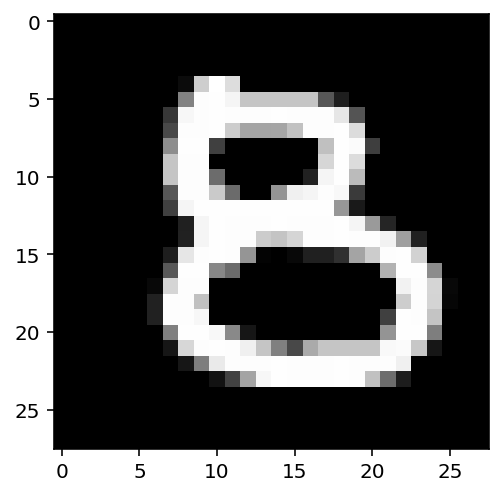

In [106]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples).***However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors.*** Thinking about sizes, we need to convert the batch of images with shape `(64, 1, 28, 28)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

***Previously you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class.*** This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [120]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

#Flatten images
inputs = images.view(images.shape[0], -1)
print(images.shape)
print(inputs.shape)

n_input = 784
n_hidden = 256
n_output = 10

w1 = torch.randn(n_input, n_hidden)
w2 = torch.randn(n_hidden, n_output)

b1 = torch.randn(1, n_hidden)
b2 = torch.randn(1, n_output)

hidden_output = sigmoid(torch.mm(inputs, w1)+b1)
output = torch.mm(hidden_output, w2)+b2

print(output.shape)
print("64 Entrees, 10 Probabilities Each")

# out = # output of your network, should have shape (64,10)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 10])
64 Entrees, 10 Probabilities Each


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. Something that looks like this:
<img src='assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way PyTorch will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `dim` keyword in `torch.sum`. Setting `dim=0` takes the sum across the rows while `dim=1` takes the sum across the columns.

In [125]:
def softmax(x):
    # Return sum for a row of values,view(-1,1) -> reshape to have proper broadcasting
    return torch.exp(x)/ torch.sum(torch.exp(x), dim = 1).view(-1, 1)
    

# Here, out should be the output of the network in the previous excercise with shape (64,10)
probabilities = softmax(output)
print(probabilities.shape)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [127]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation - (Size Input, Size Output)
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to ***inherit from `nn.Module`*** when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation and reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [128]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [135]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

### Activation functions

So far we've only been looking at the sigmoid activation function, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

### Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

It's good practice to name your layers by their type of network, for instance 'fc' to represent a fully-connected layer. As you code your solution, use `fc1`, `fc2`, and `fc3` as your layer names.

In [136]:
## SOLUTION

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation with weights
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Hidden layer 1 with sigmoid activation
        x = self.fc1(x)
        x = F.relu(x)
        # Hidden layer 2 with sigmoid activation
        x = self.fc2(x) 
        x = F.relu(x)
        # Output layer with softmax activation
        x = self.fc3(x) 
        x = F.softmax(x, dim=1)
        
        return x
    
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [137]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0176, -0.0122, -0.0250,  ...,  0.0171,  0.0318, -0.0235],
        [-0.0158, -0.0154,  0.0204,  ...,  0.0245, -0.0012,  0.0330],
        [ 0.0182, -0.0134, -0.0265,  ..., -0.0258, -0.0274, -0.0033],
        ...,
        [-0.0275, -0.0066, -0.0134,  ..., -0.0213,  0.0152, -0.0340],
        [ 0.0255,  0.0280, -0.0088,  ..., -0.0158,  0.0238,  0.0157],
        [-0.0287, -0.0091,  0.0177,  ...,  0.0217, -0.0154, -0.0030]],
       requires_grad=True)
Parameter containing:
tensor([ 8.7957e-03, -3.2230e-02,  3.3640e-02,  2.5007e-02,  3.3336e-02,
        -1.5562e-02, -9.7003e-03, -3.0537e-02,  3.1451e-03, -6.9887e-03,
         2.8346e-02,  1.7166e-02,  1.1178e-02,  2.6709e-02,  6.8892e-03,
        -2.7948e-02, -2.6798e-02,  3.4562e-02,  1.6872e-02, -4.7932e-03,
        -5.0760e-03, -2.9988e-02,  9.7773e-03,  2.4865e-02,  5.7773e-04,
         1.0158e-02, -2.8770e-02, -2.8241e-02, -1.8790e-02, -1.2214e-02,
         2.7762e-02,  1.2648e-02, -2.9117e-02,  2.8092e-0

For custom initialization, we want to modify these tensors in place. These are actually autograd Variables, so we need to get back the actual tensors with model.fc1.weight.data. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [138]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [139]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0028, -0.0088, -0.0017,  ...,  0.0101, -0.0073, -0.0075],
        [-0.0023, -0.0118,  0.0012,  ..., -0.0062, -0.0081, -0.0001],
        [-0.0126, -0.0011,  0.0104,  ..., -0.0026, -0.0010,  0.0166],
        ...,
        [ 0.0020,  0.0034,  0.0100,  ..., -0.0006, -0.0014, -0.0138],
        [ 0.0113, -0.0106,  0.0018,  ...,  0.0138, -0.0046, -0.0004],
        [-0.0176,  0.0158,  0.0174,  ...,  0.0175, -0.0147, -0.0002]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

tensor([[0.0943, 0.0969, 0.1009, 0.0991, 0.0905, 0.0876, 0.1037, 0.1058, 0.1129,
         0.1083]], grad_fn=<SoftmaxBackward>)


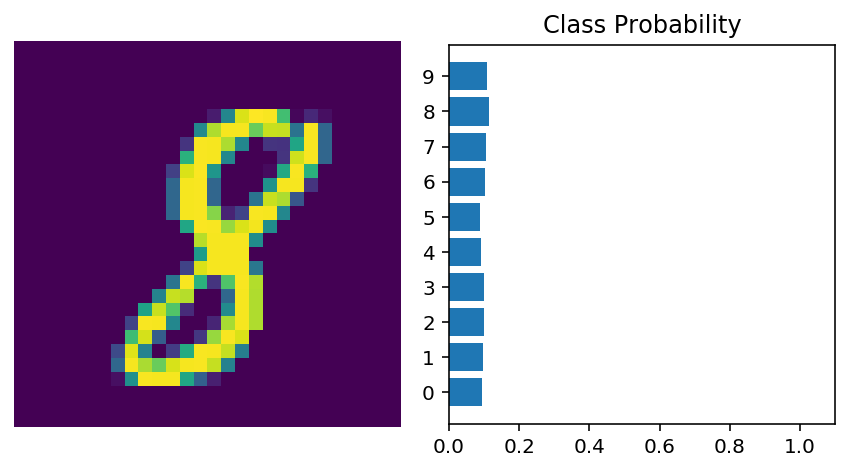

In [142]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])
print(ps)

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [143]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


Here our model is the same as before: 784 input units, a hidden layer with 128 units, ReLU activation, 64 unit hidden layer, another ReLU, then the output layer with 10 units, and the softmax output.

The operations are available by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use `model[0]`.

In [149]:
print(model[0])
print(model[0].weight)
print(model[2].weight)

Linear(in_features=784, out_features=128, bias=True)
Parameter containing:
tensor([[ 0.0099,  0.0040, -0.0058,  ..., -0.0356, -0.0065, -0.0187],
        [ 0.0263,  0.0208,  0.0216,  ..., -0.0017,  0.0233, -0.0347],
        [-0.0110,  0.0159, -0.0290,  ..., -0.0027, -0.0058, -0.0157],
        ...,
        [-0.0002, -0.0277, -0.0090,  ..., -0.0261,  0.0005,  0.0029],
        [ 0.0163,  0.0331, -0.0055,  ...,  0.0355, -0.0171, -0.0284],
        [-0.0276, -0.0139, -0.0339,  ...,  0.0301,  0.0016, -0.0193]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0421,  0.0558, -0.0448,  ...,  0.0581, -0.0103, -0.0868],
        [ 0.0768, -0.0466, -0.0787,  ...,  0.0528, -0.0488,  0.0492],
        [-0.0054, -0.0388, -0.0717,  ..., -0.0695,  0.0632, -0.0632],
        ...,
        [-0.0186, -0.0011, -0.0330,  ..., -0.0624, -0.0127,  0.0377],
        [ 0.0775,  0.0224,  0.0660,  ..., -0.0156,  0.0149,  0.0373],
        [ 0.0272, -0.0778, -0.0837,  ...,  0.0253,  0.0098,  0.0802]],
       r

You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [150]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [153]:
print(model[0])
print(model.fc1)
print(model.fc2)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
